## Image segmentation demo
Image segmentation is about using a model to assign a class to each pixel in an image, thus *segmenting* the image into different zones (such as background and foreground).

There two different flavors of image segmentation:
1. Semantic segmentation: where each pixel is independently classified into a semantic category, like 'cat'. If there are two cats in the image, the corresponding pixels are all mapped to the same generic 'cat' category.
2. Instance segmentation: which seeks not only to classify image pixels by category, but also to parse out individual object instances.  In an image with two cats in it, instance segmentation would treat "cat 1" and "cat 2" as two separate classes of pixels.

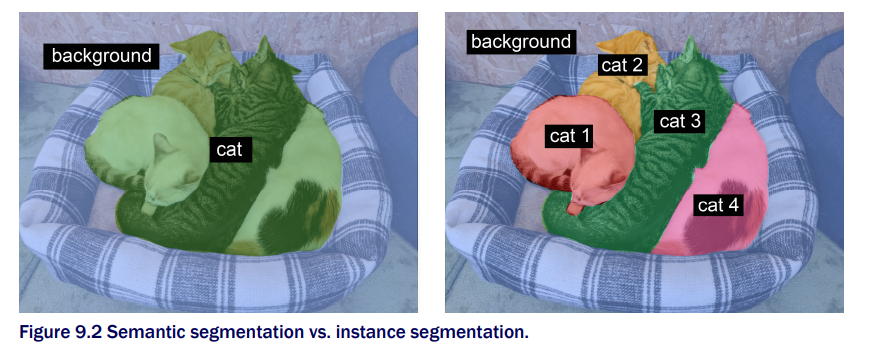

In [1]:
from IPython.display import Image

Image(filename='vs.png')

In [2]:
import os

input_dir = "/home/ubuntu/cv-project/image_segmentation_example/images/"
target_dir = "/home/ubuntu/cv-project/image_segmentation_example/annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname)
                         for fname in os.listdir(input_dir)
                         if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir, fname)
                      for fname in os.listdir(target_dir)
                      if fname.endswith(".png") and not fname.startswith(".")])

Have a quick look for input and target imgs.

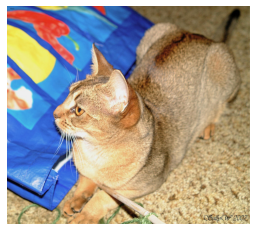

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

Display target imgs.

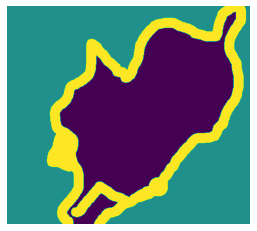

In [4]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127 
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    
img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) 
display_target(img)

1=foreground
2=background
3=contour

We subtract 1 so that the labels range from 0 to 2, then multiplying by 127. Label becomes 0(black), 127(gray), and 254(near-white). Using $color\_mode=grayscale$ so that image is treated as having a single color channel.

In [5]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

# Shuffle the file paths (they were originally sorted by breed).
# Using the same seed in both statements to ensure that the input paths and target paths stay in the same order.
random.Random(2071).shuffle(input_img_paths)
random.Random(2071).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size = img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size = img_size, color_mode = 'grayscale'))
    img = img.astype("uint8")-1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") 
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
    
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

Time to define model.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    # rescale input img to [0-1] range
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs) 
    # use padding to avoid the influence of border padding on feature map size
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    # end the model with a per-pixel three-way softmax to classify each output pixel into one of our 3 categories.
    outputs = layers.Conv2D(3, num_classes, activation="softmax", padding="same")(x) 
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

The purpose of first half convnet is to encode the images into smaller feature maps, where each spatial location contains information about a large spatial chunk of the original image.

One important difference between the first half of this model and the classification models is the way do downsampling: in the convnet, we use $MaxPooling2D$ layers to downsample feature maps. Here, we downsample by adding __strides__ to every other convolution layer.

In the case of image segmentation, we care a lot about the __spatial location__ information in the image. If we do 2$\times$2 max pooling, we will completely destory location information within each pooling window.

The second half of model is a stack of $Conv2DTranspose$ layers. A kind of *inverse* of the transformation we've applied so far, something that will *upsample* the feature maps instead of downsampling them. After compressing our inputs into feature maps of shape (25, 25, 256) via stack of $Conv2D$ layers, we can apply the corresponding sequence of $Conv2DTranspose$ layers to get back to images of shape (200, 200, 3).

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                   save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                   epochs=50,
                   callbacks=callbacks,
                   batch_size=64,
                   validation_data = (val_input_imgs, val_targets))

Displaying training & validation loss curves.

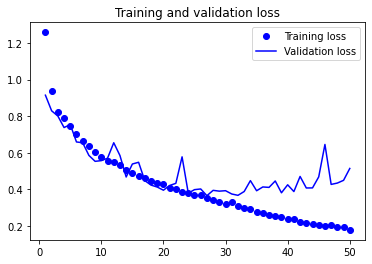

In [8]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

When epochs=26, we have the minimum validation loss.

Display a model's prediction.

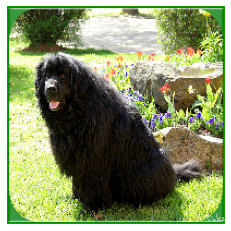

In [12]:
from tensorflow.keras.preprocessing.image import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 5
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

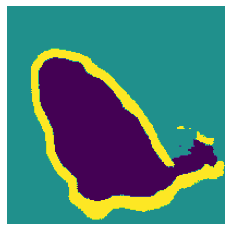

In [13]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)